In [76]:
# Imports
import bs4 as bs
import urllib.request
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import networkx as nx

# NLTK
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords


# Viz 
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

# Spacy 
import nl_core_news_sm

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\p289641\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\p289641\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Scrape demo content using url list without the company name in it!
# Be Aware! the very first URLS has to be a working one, otherwise the Listy list is not found! 
df_ga = pd.read_csv('urls_recommender_dec2.csv', sep = ';')
df_ga['Page'] = df_ga['Page'].str.lower()
search ="/items/nl-nl/vacatures/"
bool_series = df_ga["Page"].str.startswith(search, na = False) 
df_ga = df_ga[bool_series]
df_ga['Cat'] = df_ga['Page'].str.split('/').str[4]
#vakgebieden = ['data-en-analytics' , 'it', 'ict', 'traineeship']
#booly = df_ga['Cat'].isin(vakgebieden)
#df_ga = df_ga[booly]
df_ga['Url'] = "https://www.werkenbijanwb.nl"+ df_ga["Page"] 
list_url = df_ga['Url'].tolist()

ListNummer = 0
ListTotaal = []


for x in list_url:
    try:
        source = urllib.request.urlopen(x).read()
        soup = bs.BeautifulSoup(source,'lxml')
        title = soup.title.string
        ListNaam = "Vacature" + str(ListNummer)
        ListNummer = ListNummer + 1
        #print(title, "boven loop")
        for div in soup.find_all('span', class_ = 'extText'):
            Listy = []
            Listy.append(ListNaam)
            Listy.append(str(title))
            #print(title, "Onderloop")
            Listy.append(div.text)
            #print('Scraping succesfull')
    except:
        print(x, 'Scraping failed - URL does not contain a scraoable result or page does not exist.')
        
    ListTotaal.append(Listy)

# After scrape make DF
df_tekst = pd.DataFrame(ListTotaal, columns =['Nummer', 'Vacture', 'Tekst'])
df_tekst = df_tekst.drop_duplicates(subset = 'Nummer', keep = 'first')


https://www.werkenbijanwb.nl/items/nl-nl/vacatures/hulpverlening/scouts-contactonderzoek-corona-den-haag Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/hulpverlening/scouts-contactonderzoek-corona-den-haag/sollicitatie Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/marketing-en-communicatie/allround-digital-marketeer--s-gravenhage Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/marketing-en-communicatie/product-manager-anwb-rijopleiding--eindhoven Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/retail/replenisher-harderwijk Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/retail/merchandise-planner-harderwijk Scraping failed - URL not found.
https://www.werkenbijanwb.nl/items/nl-nl/vacatures/hulpverlening/scouts-contactonderzoek-corona-den-haag/sollicitatie-verzonden Scraping failed - URL not found.
https://

In [ ]:
# Strip all sentences and make them lowercase.
def sentence(x):
    tekst = x
    zinnen = tekst.replace("[^a-zA-Z]", " ").split(". ")
    #zinlijst.append(zinnen.lower().split(" "))
    return zinnen

df_tekst['Los'] = df_tekst['Tekst'].str.lower().str.replace('\W', ' ').apply(sentence)

## Stopwords imports

stopwords = nltk.corpus.stopwords.words('dutch')
stopwords.extend(['anwb', 'demo2', 'jij', 'heb', 'als'] )

#Stopword removal
df_tekst['Stopaf'] = df_tekst['Los'].apply(lambda x: ' '.join([word for word in x[0].split() if word not in (stopwords)]))

# However, for the next sectopn, it needs to be in a nested list, or single list per cell. Hence, we add the content of every
# cell to list with a quick function.
def tolistor(x):
    listy = []
    listy.append(x)
    return listy

df_tekst['Stopaf'] = df_tekst['Stopaf'].apply(tolistor)

# Now we can safely continue
# Stemming

from nltk.stem.snowball import SnowballStemmer

# Demo the technique
# stemmer.stem('medewerkers')

# Import Dutch stemmer.
stemmer = SnowballStemmer("dutch")

df_tekst['Stemmed'] = df_tekst['Stopaf'].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.

# Extract text from list and insert it back into the DF with a function. 
def selector(x):
    return x[0]

df_tekst['Stemmed'] = df_tekst['Stemmed'].apply(selector)


# lemmatization English!
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df_tekst['Lemma'] = df_tekst['Stemmed'].apply(lemmatize_text)

# Get them out of the list
def selector(x):
    s = ' '.join(x)
    return s

df_tekst['processed'] = df_tekst['Lemma'].apply(selector)

# Working towards the most important keywords using Spacy zinsontleding. This way we only select NOUNS, as these
# have proven to contain the most valuable information.

nlp = nl_core_news_sm.load()

def get_POS(x):
    list_words = []
    doc = nlp(str(x))
    list_elements = [(w.text, w.pos_) for w in doc]
    for x in list_elements:
        if x[1] == 'NOUN':
            list_words.append(x[0])
    return list_words

# Demo
# get_POS('hoe is mijn naam is naam is naam')

df_tekst['KeyNouns'] = df_tekst['processed'].apply(get_POS)

def selector(x):
    s = ' '.join(x)
    return s

df_tekst['KeyNouns'] = df_tekst['KeyNouns'].apply(selector)

# Display df
df_tekst.head()

In [57]:
########### WIP DUTCH STEMMING

In [58]:
# import nl_core_news_sm
# nlp = nl_core_news_sm.load()
# #doc = nlp("brengt manager it medior leiderschap managemen.")
# doc = nlp(df_tekst['processed'][0])
# print([(w.text, w.pos_) for w in doc])


# We willen NOUNS, ... ?

,Nummer,Vacture,Tekst,Los,Stopaf,Stemmed,Lemma,processed,KeyNouns
0,Vacature0,Vacatures - Manager IT Medior Wegenwacht,Jij brengt als Manager IT Medior leiderschap m...,[jij brengt als manager it medior leiderschap ...,[brengt manager it medior leiderschap manageme...,brengt manager it medior leiderschap managemen...,"[brengt, manager, it, medior, leiderschap, man...",brengt manager it medior leiderschap managemen...,manager leiderschap managementvaardigheden afd...
1,Vacature1,Vacatures - IT Servicedesk Medewerker,Een medewerker kan niet inloggen op net netwer...,[een medewerker kan niet inloggen op net netwe...,[medewerker inloggen net netwerk bellen jou be...,medewerker inloggen net netwerk bellen jou ben...,"[medewerker, inloggen, net, netwerk, bellen, j...",medewerker inloggen net netwerk bellen jou ben...,medewerker netwerk collega s reizen probleem p...
3,Vacature2,Vacatures - Front End Developer Verzekeren,Bij de ANWB werken we in agile SCRUM teams en ...,[bij de anwb werken we in agile scrum teams en...,[werken we agile scrum teams maakt front end d...,werken we agile scrum teams maakt front end de...,"[werken, we, agile, scrum, team, maakt, front,...",werken we agile scrum team maakt front end dev...,team onderdeel aandacht kwaliteit code verantw...
4,Vacature3,Vacatures - Integratie Tester,Heb jij lef? Ben jij stress bestendig? En leve...,[heb jij lef ben jij stress bestendig en lev...,[lef stress bestendig lever onvoorwaardelijke ...,lef stress bestendig lever onvoorwaardelijke k...,"[lef, stress, bestendig, lever, onvoorwaardeli...",lef stress bestendig lever onvoorwaardelijke k...,stress lever kwaliteit integratie callcenter m...
5,Vacature4,Vacatures - Integratie Analist,Heb jij lef? Ben jij stress bestendig? En leve...,[heb jij lef ben jij stress bestendig en lev...,[lef stress bestendig lever onvoorwaardelijke ...,lef stress bestendig lever onvoorwaardelijke k...,"[lef, stress, bestendig, lever, onvoorwaardeli...",lef stress bestendig lever onvoorwaardelijke k...,stress lever kwaliteit integratie analist call...


In [59]:
# Do the cosine calculations for all available ids. 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df_tekst['KeyNouns'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

RangeIndex(start=0, stop=16, step=1)

In [65]:
# Restructure the index of the df for further visualisation. 
df_tekst = df_tekst.reset_index(drop = True)
df_tekst['Nummer'] = df_tekst.index 
df_tekst.drop('Nummer', axis = 1, inplace = True)
df_cos = pd.DataFrame(cosine_sim)

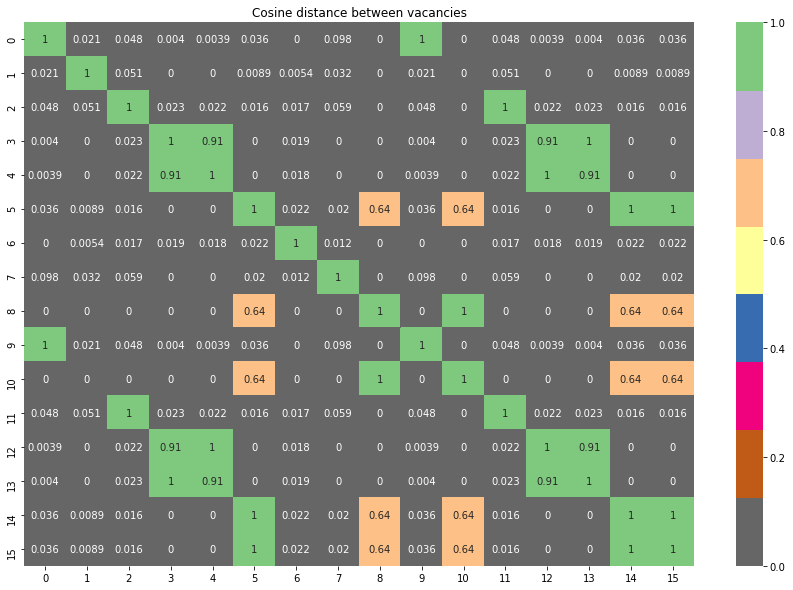

In [75]:
# Plotting the vacancies. 
import matplotlib as plt
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.title("Cosine distance between vacancies")
sns.heatmap(df_cos, cmap="Accent_r", annot=True, )

#YlGnBu

In [ ]:
# Getting to the best possible match per ID

In [68]:
# Lets create a quick df that we can use later to combine with our predictions. 
df_title = df_tekst['Vacture']
df_title = pd.DataFrame(df_title)

In [69]:
merged =  df_cos.merge(df_title, left_index=True, right_index= True)

In [70]:
def get_closest(df, col, topx):
    ''' This function allows you get the top x number of similair job vacancies based on cosine.
        Insert the DF name with cosines distances;
        the index of the job;
        the top (n).
        Be aware that a very high similairy may not be good, as this can be the same vacancy but in a different catagory.
    '''
    print('De top ', topx, ' aansluitende vacatures voor: ', df_tekst['Vacture'][col].split('-', 1)[-1].lstrip())
    new = pd.DataFrame(df[col].nlargest(topx + 3)).merge(df_title, left_index = True, right_index = True)
    title = df_tekst['Vacture'][col].split('-', 1)[-1].lstrip()
    new[str(title)] = new[col]
    new = new[['Vacture', str(title)]].drop_duplicates()
    return new.sort_values(by=[str(title)], ascending = False).head(topx)
    if topx < len(df):
        print("Could not show", topx, 'examples, as there is not such an amount of data!')

In [71]:
# Pcik your ID from the list below, and use the function to get the next top recommendations.
df_title

,Vacture
0,Vacatures - Manager IT Medior Wegenwacht
1,Vacatures - IT Servicedesk Medewerker
2,Vacatures - Front End Developer Verzekeren
3,Vacatures - Integratie Tester
4,Vacatures - Integratie Analist
5,Vacatures - iOS Developer
6,Vacatures - Senior Cloud Data Integration Engi...
7,Vacatures - Senior Data Engineer
8,Vacatures - Android Developer
9,Vacatures - Manager IT Medior Wegenwacht


In [72]:
# The function below gives you the top x for every vacancy!
topx = None
while topx is None:
    try:
        topx = int(input("Enter the top x you want: "))
    except ValueError:
        print('Enter an integer value! Foei')
vac = None
while vac is None:
    try:
        vac = int(input("Enter the Vacature ID: "))
    except ValueError:
        print('Enter a vacature ID from the list above!')
        

get_closest(df_cos, vac, topx)

Enter the top x you want: 5
Enter the Vacature ID: 4
De top  5  aansluitende vacatures voor:  Integratie Analist


,Vacture,Integratie Analist
4,Vacatures - Integratie Analist,1.000000
3,Vacatures - Integratie Tester,0.913518
2,Vacatures - Front End Developer Verzekeren,0.022364
6,Vacatures - Senior Cloud Data Integration Engi...,0.018035
0,Vacatures - Manager IT Medior Wegenwacht,0.003874
